In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, make_scorer
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

## Итоговая практика по алгоритмам кластеризации
В нашем распоряжении есть данные о 8950 держателях кредитных карт одного из банков Нью-Йорка. Банк собрал достаточно много данных об этих людях и о том, как они пользовались кредитными картами за последние полгода.

Маркетологи хотят запустить рекламную кампанию, однако для этого необходимо произвести сегментацию клиентов, чтобы сделать акционное предложение более персонализированным. Мы попробуем использовать все известные нам методы кластеризации и посмотрим на получившиеся результаты.

- CUST_ID — идентификационный номер держателя карты;
- BALANCE — баланс, доступный для совершения покупок;
- BALANCEFREQUENCY — как часто обновляется показатель баланса (1 — часто, 0 — нечасто);
- PURCHASES — количество покупок, оплаченных со счёта;
- ONEOFFPURCHASES — максимальная сумма единовременной покупки;
- INSTALLMENTSPURCHASES — сумма покупок, сделанных в рассрочку;
- PURCHASESFREQUENCY — как часто в целом совершаются покупки (1 — часто, 0 — нечасто);
- ONEOFFPURCHASESFREQUENCY — частота совершения единовременных покупок (1 — часто, 0 — нечасто);
- PURCHASESINSTALLMENTSFREQUENCY — частота совершения покупок в рассрочку (1 — часто, 0 — нечасто);
- CASHADVANCEFREQUENCY — частота внесения авансовых платежей;
- CASHADVANCETRX — количество транзакций с авансовыми взносами;
- PURCHASESTRX — количество совершённых транзакций с покупками;
- CREDITLIMIT — кредитный лимит держателя карты;
- PAYMENTS — сумма платежей пользователя;
- MINIMUM_PAYMENTS — сумма минимального платежа пользователя;
- PRCFULLPAYMENT — выплаченный процент от полного платежа;
- TENURE — срок обслуживания кредитной карты.

In [18]:
df = pd.read_csv('./data/CC GENERAL.csv')

### Задание 7.2
Теперь приступим к анализу данных. По традиции начнём его с проверки данных на наличие пропущенных значений. Сколько всего пропусков в данных?

In [19]:
print(f'{df.isna().sum().sum()} всего пропусков в данных')

314 всего пропусков в данных


### Задание 7.3
Заполните все пропуски средними арифметическими для признаков. Каким будет среднее арифметическое для признака `MINIMUM_PAYMENTS` (если считать после заполнения пропущенных значений)? Округлите результат до двух знаков после точки-разделителя.

In [20]:
df.fillna(df.mean(),inplace=True)

In [21]:
print(f'{df.MINIMUM_PAYMENTS.mean():.2f}')

864.21


Задание 7.4
1 point possible (graded)
Теперь нормализуйте данные с помощью `StandardScaler()`. Для получившейся матрицы нормализованных признаков выведите самое первое значение в самой первой строке (`X_norm[0][0]`). Округлите до двух знаков после точки-разделителя.


>Не забудьте предварительно удалить признак CUST_ID — он не поможет при кластеризации, так как не несёт никакой содержательной информации.>

In [22]:
X = df.drop(columns='CUST_ID')

In [24]:
scaler =StandardScaler()
X_norm = scaler.fit_transform(X)

In [27]:
round(X_norm[0][0],2)

-0.73

### Задание 7.5
Теперь можем приступать к кластеризации. Начнём с самого простого и популярного метода — `k-means`. Для того чтобы его применить, необходимо узнать число кластеров. Наилучший способ сделать это — применить коэффициент силуэта. Найдите с его помощью оптимальное количество кластеров, перебрав диапазон от 2 до 9 включительно.

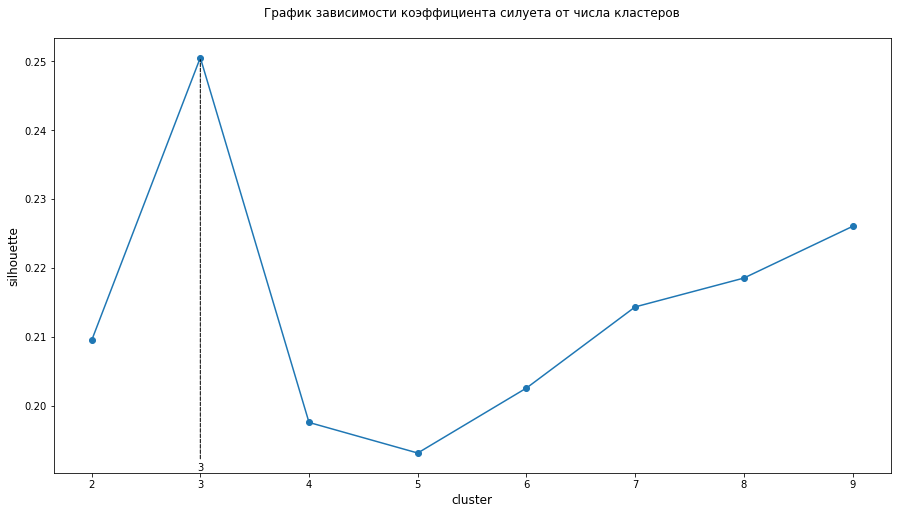

Wall time: 14.4 s


In [35]:
%%time
clusters_num = range(2,10)
silhouettes = pd.Series(dtype='float64')

for n_clusters in clusters_num:
    kmeans = KMeans(n_clusters=n_clusters,random_state=42)
    kmeans.fit(X_norm)
    silhouettes = silhouettes.append(pd.Series(silhouette_score(X_norm, kmeans.labels_),
                                               index=[n_clusters]))
    
plt.figure(figsize=(15,8))
plt.title('График зависимости коэффициента силуета от числа кластеров\n')
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot(clusters_num,silhouettes,marker='o')

arrowprops={'arrowstyle': '-', 'ls':'--'}
plt.annotate(str(silhouettes.idxmax()), 
             xy=(silhouettes.idxmax(),silhouettes.max()), 
             xytext=(silhouettes.idxmax(), 0), 
             textcoords=plt.gca().get_xaxis_transform(),
             arrowprops=arrowprops,
             va='bottom', 
             ha='center')
plt.show()

### Задание 7.6
Теперь реализуем непосредственно кластеризацию `k-means` с оптимальным количеством кластеров, которое мы определили в предыдущем задании.

Сколько человек оказалось в самой малочисленной группе?

In [41]:
kmeans = KMeans(n_clusters=3,random_state=42)
kmeans.fit(X_norm)

_, counts = np.unique(kmeans.labels_,return_counts=True)  
counts.min()

1235

### Задание 7.7
Попробуем применить `DBSCAN`. Для начала реализуйте его с параметрами по умолчанию.

Сколько кластеров было выделено?

In [82]:
dbs = DBSCAN()
dbs.fit(X_norm)

clusrers_labels = np.setdiff1d(np.unique(dbs.labels_),[-1])
len(clusrers_labels)

38

### Задание 7.8
В предыдущем задании получилось очень много кластеров. Возможно, это случилось потому, что мы взяли параметры по умолчанию, а результат алгоритма DBSCAN, как вы помните, очень чувствителен к ним.

Давайте попробуем с помощью цикла перебрать параметр `eps` по значениям, заданным как `np.arange(0.1,3,0.2)`, а параметр `min_samples` — по значениям, заданным как `range(1,20,4)`. Найдите комбинацию, которая даёт максимальное значение коэффициента силуэта.

In [196]:
# dbs = DBSCAN()
# param_grid = {
#     'eps': np.arange(0.1,3,0.2), 
#     'min_samples': range(1,20,4)
# }
# silhouette = make_scorer(silhouette_score,random_state=42)?

# search = GridSearchCV(
#     estimator = dbs,
#     param_grid = param_grid,
#     scoring=silhouette,
#     n_jobs=-1
#     )

# search.fit(X_norm)
# search.best_params_

In [195]:
%%time
search_results = []
param_grid = {
    'eps': np.arange(0.1,3,0.2), 
    'min_samples': range(1,20,4)  
}
for param in ParameterGrid(param_grid):
    dbs = DBSCAN(**param)
    dbs.fit(X_norm)
    results = {**{k:v for k,v in dbs.get_params().items() if v},
               **dict(silhouette=silhouette_score(X_norm, dbs.labels_))}
    search_results.append(results)
    
pd.DataFrame(search_results).sort_values(by='silhouette',ascending=False).iloc[0]

Wall time: 4min 1s


algorithm           auto
eps                  2.9
leaf_size             30
metric         euclidean
min_samples            5
silhouette      0.617345
Name: 71, dtype: object

### Задание 7.9
Теперь давайте реализуем агломеративную иерархическую кластеризацию. Переберите количество кластеров в диапазоне от 3 до 9 включительно и найдите то их число, которое будет давать максимальный коэффициент силуэта.

In [204]:
%%time
silhouettes = pd.Series(dtype='float64')
for n_clusters in range(3,10,1):
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    silhouettes = silhouettes.append(pd.Series(silhouette_score(X_norm,ac.fit_predict(X_norm)),
                                               index=[n_clusters]))
    
silhouettes.idxmax()

Wall time: 36.7 s


6

### Задание 7.10
Сколько будет наблюдений в самом многочисленном классе, если мы обучим на наших данных модель агломеративной иерархической кластеризации с количеством кластеров, полученным в предыдущем задании?

In [212]:
ac = AgglomerativeClustering(n_clusters=6,linkage = 'average')
labels = ac.fit_predict(X_norm)

_, counts = np.unique(labels,return_counts=True)
counts.max()

8921